Ideas:
- look at each center for convergence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from hashable import *

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def center_position(points):
    c = np.mean(points, axis=0)
    assert len(c) == len(points[0])
    return c

In [3]:
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [4]:
def center_for_point_index(p, centers):
    """
    returns the index of the center that is closest to p
    """
    return np.argmin(centers - p)
def center_for_point(p, centers):
    """
    returns the center closest to p
    """
    return centers[center_for_point_index(p, centers)]

In [5]:
def neigh_r(p1, p2, centers, r):
    """
    p1, p2: the two data points
    centers: the neurons
    r: int radius
    returns 1 iff the two points belong to centers at most r hops away from eachother.
    eg neigh_r(0) returns 1 only if p1 and p2 belong to the same center
    
    In this 4x4 map A and B are 2 hops away from eachother.
    [[ 0,  1,  2,  3],
     [ A,  5,  B,  7],
     [ 8,  9, 10, 11],
     [12, 13, 14, 15]]
    """
    i1 = center_for_point_index(p1, centers)
    i2 = center_for_point_index(p2, centers)
    
    if i1 == i2:
        return 1
    
    n =len(centers)
    assert np.sqrt(n) == int(np.sqrt(n)) # make sure n is a square number
    size_k = int(np.sqrt(n))
    
    col_i1 = i1 % size_k
    row_i1 = int(i1 / size_k)
    
    col_i2 = i2 % size_k
    row_i2 = int(i2 / size_k)
    
    dist = max(abs(col_i1 - col_i2), abs(row_i1 - row_i2))
    
    return 1 if dist <= r else 0

In [6]:
def stab_score_dict(stability_dict):
    score = 0
    for stab in stability_dict.values():
        diff = min(1-stab, stab)
        score += ((1+diff)**2)-1
    return score/len(stability_dict)

In [7]:
def update_stab_dict(stability_dict, centers, t, r):
    for p, stab in stability_dict.items():
        n = neigh_r(p[0].unwrap(), p[1].unwrap(), centers, r)
        stability_dict[p] = (t*stab + n) / (t+1)

In [8]:
def update_stab_dict_moving_avg(stability_dict, stability_history, centers, N, r):
        for p, stab in stability_dict.items():
            n = neigh_r(p[0].unwrap(), p[1].unwrap(), centers, r)
            stability_history[p].append(n)
            h = stability_history[p]
            m = max(0, len(h)-N-1)
            stability_dict[p] = np.mean(h[m:])
            

In [9]:
def closest_point_index(data, point):
    """
    returns the index in data that represents the vector closest to point
    """
    return np.argmin(np.sum(abs(data[:] - point), 1))
    

In [10]:
def init_stab_dict_close_pairs(data, size):
    d = {}
    seen = set()
    i = 0
    while len(d) < size and i < len(data):
        if i not in seen:
            p1 = data[i, :]
            i2 = closest_point_index(data, p1)
            p2 = data[i2, :]
            d[(hashable(p1), hashable(p2))] = 0.5
            seen.add(i)
            seen.add(i2)
            i += 1
    return d
        

In [11]:
def init_stab_dict_random_pairs(data, size):
    d = {}
    seen = set()
    i = 0
    while len(d) < size and i < len(data):
        if i not in seen:
            p1 = data[i, :]
            i2 = random.randint(i+1, len(data)-1)
            p2 = data[i2, :]
            d[(hashable(p1), hashable(p2))] = 0.5
            seen.add(i)
            seen.add(i2)
        i += 1
    return d
        

In [12]:
def init_stab_dict_random_pairs_biased_to_close(data, size):
    d = {}
    seen = set()
    i = 0
    while len(d) < size and i < len(data):
        if i not in seen:
            p1 = data[i, :]
            i2 = i+1
            if random.choice([False, False, True, True, True]):
                i2 = random.randint(i+1, len(data)-1)
            else:
                i2 = closest_point_index(data, p1)
            random.randint
            p2 = data[i2, :]
            d[(hashable(p1), hashable(p2))] = 0.5
            seen.add(i)
            seen.add(i2)
        i += 1
    return d
        

In [13]:
def init_stab_hist(stab_dict):
    hd = {}
    for p in stab_dict:
        hd[p] = []
    return hd

In [14]:
def kohonen(max_iter=1000, R=1, init_eta=0.1):
    """Example for using create_data, plot_data and som_step.
    """
    
    dim = 28*28
    data_range = 255.0
    
    # load in data and labels    
    data = np.array(np.loadtxt('data.txt'))
    labels = np.loadtxt('labels.txt')

    # select 4 digits    
    name = 'Lukas Pestalozzi' 
    targetdigits = [0, 1, 2, 9] # name2digits(name) # assign the four digits that should be used
    print(targetdigits) # output the digits that were selected
    # this selects all data vectors that corresponds to one of the four digits
    data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    
    dy, dx = data.shape
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = 2.0
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    eta = init_eta
    
    #set the maximal iteration count
    tmax = max_iter
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    
    
    T = 1
    #N = 500
    stab_dict = init_stab_dict_random_pairs_biased_to_close(data, data.shape[0]*0.05)
    #stab_hist = init_stab_hist(stab_dict)
    print("nbr sample: ", len(stab_dict))
    update_stab_dict(stab_dict,centers, T, R)
    T+=1
    
    print("init vals:", list(stab_dict.values()))
    plt.hist(list(stab_dict.values()), bins=100)
    plt.title("init hist")
    plt.show()
    
    old_centers_center = center_position(centers)
    diff_center = []
    diff_center_mean = []
    stab_scores = []
    for t, i in enumerate(i_random):
        som_step(centers, data[i,:],neighbor,eta,sigma)
        centers_center = center_position(centers)
        diff_center.append(distance(old_centers_center, centers_center))
        diff_center_mean.append(np.mean(diff_center))
        #print(diff_center[-1])
        old_centers_center = centers_center
        
        if t % 10 == 0:
            update_stab_dict(stab_dict,centers, T, R)
            T+=1
            stab_scores.append((stab_score_dict(stab_dict), t))
        
        
        if t % 1000 == 0:
            print(t, "score(", stab_scores[-1][0],")", end="")
            #plt.hist(list(stab_dict.values()), bins=100)
            #plt.title("hist iter "+str(t))
            #plt.show()
                               
        if t % 100 == 0:
            print(".", end="")
        
        

    
    #plt.plot(diff_center_mean)
    plt.plot([v[1] for v in stab_scores], [v[0] for v in stab_scores])
    plt.title("stab_scores")
    plt.show()
    print("vals: ", list(stab_dict.values()))
    plt.hist(list(stab_dict.values()), bins=100)
    plt.title("final hist")

    """
    stab_matrix_flat = []
    for i1 in range(0, np.shape(stab_matrix)[0]):
        for i2 in range(i1, np.shape(stab_matrix)[1]):
            stab_matrix_flat.append(stab_matrix[i1][i2])
    
    print("len flat", len(stab_matrix_flat), "shape matrix", np.shape(stab_matrix))
    plt.hist(stab_matrix_flat, bins=100)

    # for visualization, you can use this:
    for i in range(size_k**2):
        plt.subplot(size_k,size_k,i+1)
        
        plt.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plt.axis('off')
        """
   
    

[0, 1, 2, 9]
nbr sample:  100
init vals: [0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75]


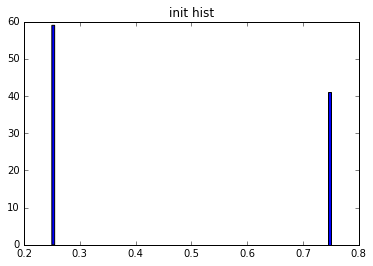

0 score( 0.41444444444444484 )..........1000 score( 0.030096144782731562 )..........2000 score( 0.02272489019388969 )..........3000 score( 0.02211885544990132 )..........4000 score( 0.021758831099261914 )..........5000 score( 0.02077392503823959 )..........6000 score( 0.019916751235530484 )..........7000 score( 0.019625118118043138 )..........8000 score( 0.019060264357352415 )..........9000 score( 0.019149347137448754 )..........10000 score( 0.018913140936115055 )..........11000 score( 0.019105932966137808 )..........12000 score( 0.019476240128412637 )..........13000 score( 0.018935810800861694 )..........14000 score( 0.018873724922005477 )..........15000 score( 0.0191424514023626 )..........16000 score( 0.01884465301919475 )..........17000 score( 0.018581678079062386 )..........18000 score( 0.01827459872296394 )..........19000 score( 0.018310892252159393 )..........20000 score( 0.01861067360516891 )..........21000 score( 0.018619893822854183 )..........22000 score( 0.01889461385240164

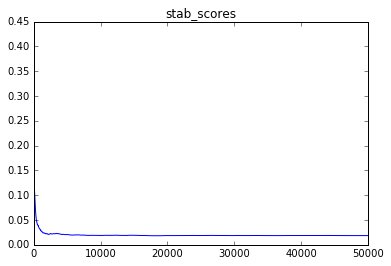

vals:  [0.0010995601759296299, 9.996001599360253e-05, 0.9999000399840065, 9.996001599360253e-05, 9.996001599360253e-05, 0.0036985205917633044, 0.0008996401439424247, 9.996001599360253e-05, 0.1342463014794086, 0.9999000399840065, 0.00029988004798080854, 0.00029988004798080567, 0.9999000399840065, 0.9999000399840065, 0.9999000399840065, 9.996001599360253e-05, 0.9999000399840065, 0.7268092762894852, 0.9999000399840065, 0.9999000399840065, 9.996001599360253e-05, 9.996001599360253e-05, 0.040683726509396244, 0.9999000399840065, 9.996001599360253e-05, 9.996001599360253e-05, 9.996001599360253e-05, 9.996001599360253e-05, 9.996001599360253e-05, 0.9999000399840065, 0.9999000399840065, 0.9999000399840065, 0.9999000399840065, 0.18022790883646533, 0.9999000399840065, 9.996001599360253e-05, 9.996001599360253e-05, 0.9999000399840065, 0.9999000399840065, 0.9999000399840065, 0.9999000399840065, 0.9999000399840065, 0.9999000399840065, 9.996001599360253e-05, 0.9999000399840065, 0.9999000399840065, 9.99600

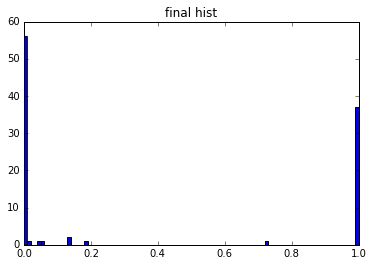

In [20]:
kohonen(max_iter=50000, R=0)

In [16]:
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
        

In [17]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

In [18]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])